# 0. Setup

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sktime
import statsmodels

RANDOM_STATE = 42

In [49]:
# Chart style settings
import matplotlib.style as style
style.use({'font.family': 'Monospace', 'font.size': 12, })

In [50]:
# Data folders
from pathlib import Path
raw_data_dir = Path.cwd().parent / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)
processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [51]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#4BADFEBF", alpha=0.2, hatch='/', label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#4BADFE81", alpha=0.2, hatch='//', label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#4BADFE4D", alpha=0.2, hatch='///', label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#4B8AFEBE", alpha=0.2, label='Energy-price crisis')
    }

In [52]:
# Forecast horizon for TabPFN
HORIZON = 12

In [53]:
# Helper function to evalutate TabPFN predictions

def evaluate_tabpfn(
    pred,
    train_tsdf,
    test_tsdf_ground_truth,
    item_id='retail_series',
    horizon=12,
    seasonal_period=12
):
    """
    Parameters
    ----------
    pred : TabPFN prediction result (MultiIndex DataFrame with quantiles)
    train_tsdf : Training TimeSeriesDataFrame
    test_tsdf_ground_truth : Test TimeSeriesDataFrame with ground truth
    item_id : str, default 'retail_series'
    horizon : int, forecast horizon used
    seasonal_period : int, for MASE calculation

    Returns
    -------
    dict : Metrics including MAE, MASE, pinball losses, coverage, interval width
    """
    from sktime.performance_metrics.forecasting import (
        mean_absolute_error, mean_absolute_scaled_error
    )
    from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

    # Extract predictions for the item (already in correct format)
    pred_slice = pred.loc[item_id]

    # Extract ground truth
    y_true = (
        test_tsdf_ground_truth
        .groupby('item_id')
        .tail(horizon)
        .loc[item_id]['target']
    )

    # Extract quantiles as simple Series
    q_low = pred_slice[0.1]
    q_med = pred_slice[0.5]
    q_high = pred_slice[0.9]

    # Align indices (in case of mismatch)
    y_true = y_true.reindex(q_med.index)

    # Point metrics
    mae = float(mean_absolute_error(y_true, q_med))

    # MASE (requires training data)
    y_train = train_tsdf.loc[item_id]['target']
    mase = float(mean_absolute_scaled_error(y_true, q_med, y_train=y_train, sp=seasonal_period))

    # Probabilistic metrics
    pinball = PinballLoss()

    # Create proper sktime format: DataFrame with MultiIndex columns
    # Each quantile needs to be a column with (variable, alpha) MultiIndex
    y_pred_low = pd.DataFrame(
        q_low.values,
        index=q_low.index,
        columns=pd.MultiIndex.from_tuples([('target', 0.1)], names=['variable', 'alpha'])
    )

    y_pred_high = pd.DataFrame(
        q_high.values,
        index=q_high.index,
        columns=pd.MultiIndex.from_tuples([('target', 0.9)], names=['variable', 'alpha'])
    )

    pin_low = float(pinball(y_true, y_pred_low))
    pin_high = float(pinball(y_true, y_pred_high))

    # Coverage and interval width
    coverage_80 = float(((y_true >= q_low) & (y_true <= q_high)).mean())
    interval_width = float((q_high - q_low).mean())

    return {
        "mae": mae,
        "mase": mase,
        "pinball_0.1": pin_low,
        "pinball_0.9": pin_high,
        "coverage_80": coverage_80,
        "mean_interval_width": interval_width,
    }

### Client setup

In [54]:
import tabpfn_client
import dotenv
import os

# check that the API key is available in .env
if os.getenv("PRIORLABS_API_KEY") is None:
    raise ValueError("Please set the PRIORLABS_API_KEY in the .env file")

dotenv.load_dotenv()
token = dotenv.get_key(dotenv.find_dotenv(), "PRIORLABS_API_KEY")
tabpfn_client.set_access_token(token)

# 1. Modelling using TabPFN

## Prediction 1 - "leaking vanilla"

While the data formatted according to TabPFN requirements and target is set as NaN for the test period, the model sees all exog variables creating information leakage.

### 1.1 Setup

In [55]:
from tabpfn_time_series.plot import plot_actual_ts
from autogluon.timeseries import TimeSeriesDataFrame

data_path = processed_data_dir / "model_data.pkl"
meta_path = processed_data_dir / "meta_data.pkl"

df = pd.read_pickle(data_path)
df_reset = df.reset_index()
df_reset = df_reset.rename(columns={'online_retail_sales_share': 'target'})
df_reset['item_id'] = 'retail_series'

# Temporal and time-based features
df_full = df_reset.copy()
df_full["month"] = df_full["date"].dt.month
df_full["day_of_year"] = df_full["date"].dt.dayofyear
df_full["week_of_year"] = df_full["date"].dt.isocalendar().week.astype("int")
df_full["quarter"] = df_full["date"].dt.quarter

# Lag / rolling features (properly shifted to avoid leakage)
for lag in [1, 2, 6, 12]:
    df_full[f"lag_{lag}"] = df_full.groupby("item_id")["target"].shift(lag)

for w in [7, 14, 30]:
    df_full[f"roll_mean_{w}"] = (
        df_full.groupby("item_id")["target"]
               .shift(1)   # to prevent target leakage in the rolling mean features
               .rolling(window=w, min_periods=1).mean()
    )

# Remove rows with missing target values
df_full = df_full.dropna(subset=["target"])

tsdf = TimeSeriesDataFrame.from_data_frame(
    df_full,
    id_column="item_id",
    timestamp_column="date",
    static_features_df=None
)

train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=HORIZON)
test_tsdf = test_tsdf_ground_truth[-HORIZON:].copy()
test_tsdf['target'] = np.nan

print(f"Training data shape: {train_tsdf.shape}")
print(f"Groundtruth data shape: {test_tsdf_ground_truth.shape}")
print(f"Test data shape: {test_tsdf.shape}")
print(f"Prediction length: {HORIZON}")

# plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

Training data shape: (115, 19)
Groundtruth data shape: (127, 19)
Test data shape: (12, 19)
Prediction length: 12


### 1.2 Prediction

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 446.16it/s]
Processing: 100%|██████████| [00:01<00:00]


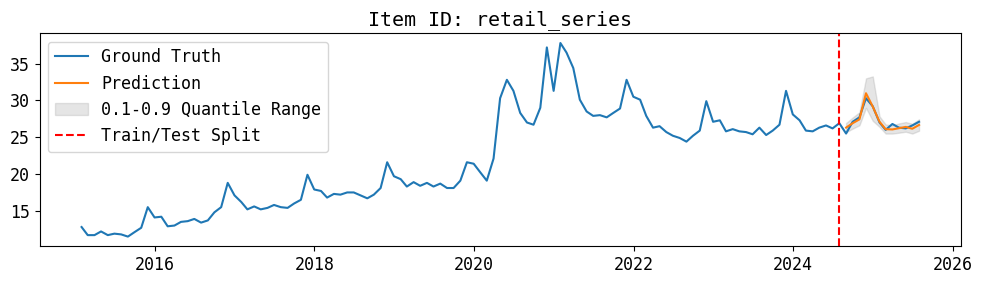

In [56]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)
pred = predictor.predict(train_tsdf, test_tsdf)

test_future_tsdf = test_tsdf_ground_truth.groupby('item_id').tail(n=HORIZON)
pred_future_tsdf = pred
train_future_tsdf = train_tsdf

plot_pred_and_actual_ts(
    pred=pred_future_tsdf,
    train=train_future_tsdf,
    test=test_future_tsdf,
    item_ids=['retail_series'],
    show_points=False,
)

### 1.3 Evaluate

In [57]:
# Evaluate using the wrapper
metrics_1 = evaluate_tabpfn(
    pred=pred,
    train_tsdf=train_tsdf,
    test_tsdf_ground_truth=test_tsdf_ground_truth,
    item_id='retail_series',
    horizon=HORIZON,
    seasonal_period=12
)

metrics_1

{'mae': 0.34004551569620717,
 'mase': 0.11069749720831014,
 'pinball_0.1': 0.10659332911173496,
 'pinball_0.9': 0.12099306742350231,
 'coverage_80': 0.8333333333333334,
 'mean_interval_width': 1.9866345723470074}

### 1.4 Plot

In [58]:
# Data prep
train_df = (train_tsdf.loc['retail_series'].reset_index().assign(series='train').rename(columns={'target': 'value'}))
actual_df = (test_tsdf_ground_truth.groupby('item_id').tail(12).loc['retail_series'].reset_index().assign(series='actual').rename(columns={'target': 'value'}))

# median forecast
med_df = (pred.loc['retail_series', 0.5].to_frame('value').reset_index().assign(series='forecast'))

# lower / upper 80 % band
lo_df = (pred.loc['retail_series', 0.1].to_frame('value').reset_index().assign(series='lower80'))
hi_df = (pred.loc['retail_series', 0.9].to_frame('value').reset_index().assign(series='upper80'))

plot_df = pd.concat([train_df, actual_df, med_df, lo_df, hi_df], ignore_index=True)

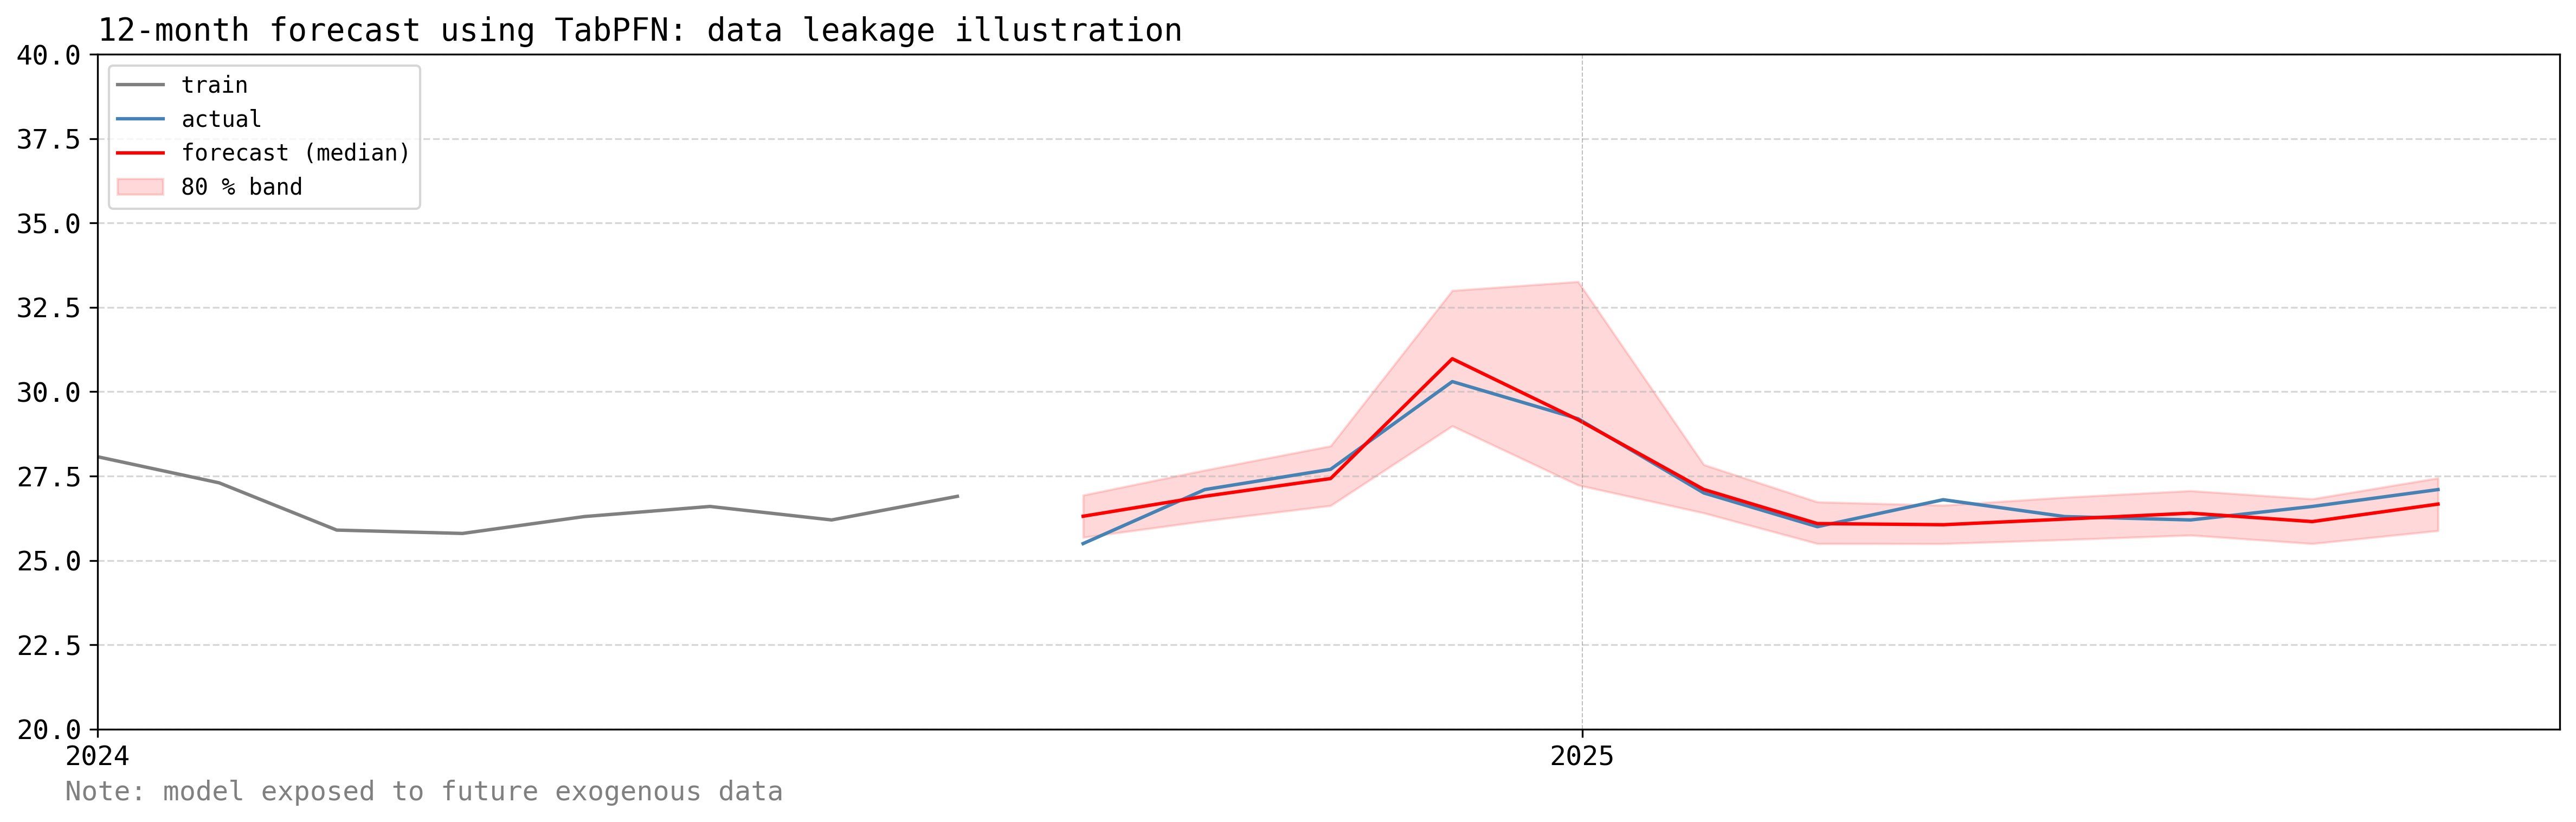

In [59]:
# Plotting
plt.figure(figsize=(16, 5), dpi=300)

sns.lineplot(data=plot_df.query("series == 'train'"), x='timestamp', y='value', linewidth=1.5, color='grey', label='train')
sns.lineplot(data=plot_df.query("series == 'actual'"), x='timestamp', y='value', linewidth=1.5, color='steelblue', label='actual')
sns.lineplot(data=plot_df.query("series == 'forecast'"), x='timestamp', y='value', linewidth=1.5, color='red', label='forecast (median)')

lower = plot_df.query("series == 'lower80'").set_index('timestamp')['value']
upper = plot_df.query("series == 'upper80'").set_index('timestamp')['value']
plt.fill_between(lower.index, lower, upper, color='red', alpha=.15, label='80 % band')

ax = plt.gca()
time_range = pd.date_range(start=plot_df['timestamp'].min(),
                           end=plot_df['timestamp'].max(),
                           freq='YS')  # Year start frequency
ax.set_xticks(time_range)
ax.set_xticklabels([t.year for t in time_range])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans
# event_spans = add_event_spans(ax)

ax.legend(loc="upper left", fontsize=10)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title(f'{HORIZON}-month forecast using TabPFN: data leakage illustration', fontsize=14, loc='left')
plt.figtext(0.03, 0, 'Note: model exposed to future exogenous data', fontsize=12, color='grey')

ax.set_xlim(pd.Timestamp('2024-01-01'), plot_df['timestamp'].max() + pd.Timedelta(days=30))
ax.set_ylim(20, 40)

# plt.savefig('../outputs/figures/UK_online_retail_share_trend_with_spans.png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

## Prediction 2 - Progressive exog masking (no leakage)  

TabPFN predicts each future value separately. For each prediction it is necessary to expose only relevant exog information, masking later periods.  
Mask future exogenous variables: when predicting t+h, only exog up to t+h are available.

### 2.1 Setup

In [60]:
from tabpfn_time_series.plot import plot_actual_ts
from autogluon.timeseries import TimeSeriesDataFrame

data_path = processed_data_dir / "model_data.pkl"
meta_path = processed_data_dir / "meta_data.pkl"

df = pd.read_pickle(data_path)
df_reset = df.reset_index()
df_reset = df_reset.rename(columns={'online_retail_sales_share': 'target'})
df_reset['item_id'] = 'retail_series'

# Temporal and time-based features
df_full = df_reset.copy()
df_full["month"] = df_full["date"].dt.month
df_full["day_of_year"] = df_full["date"].dt.dayofyear
df_full["week_of_year"] = df_full["date"].dt.isocalendar().week.astype("int")
df_full["quarter"] = df_full["date"].dt.quarter

# Lag / rolling features
for lag in [1, 2, 6, 12]:
    df_full[f"lag_{lag}"] = df_full.groupby("item_id")["target"].shift(lag)

for w in [7, 14, 30]:
    df_full[f"roll_mean_{w}"] = (
        df_full.groupby("item_id")["target"]
               .shift(1)  # to prevent target leakage in the rolling mean features
               .rolling(window=w, min_periods=1).mean()
    )

# Remove rows with missing target values
df_full = df_full.dropna(subset=["target"])

tsdf = TimeSeriesDataFrame.from_data_frame(
    df_full,
    id_column="item_id",
    timestamp_column="date",
    static_features_df=None
)

train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=HORIZON)
test_tsdf = test_tsdf_ground_truth[-HORIZON:].copy()

# Mask target (always NaN)
test_tsdf['target'] = np.nan

# ADDED IN PREDICTION 2: progressive masking: mask future exogenous variables values

# When predicting target(t+h), the model should only see exog up to t+h to prevents data leakage from future exogenous values
exog_cols = ['cpi_inf', 'rpi_ex_cpi', 'eff_fx_inf', 'cci', 'boe_rate']
item_id = 'retail_series'
retail_mask = test_tsdf.index.get_level_values('item_id') == item_id
retail_timestamps = test_tsdf[retail_mask].index.get_level_values('timestamp')

# For each horizon h (0-indexed), mask exog variables at horizons > h
for h in range(len(retail_timestamps)):
    current_timestamp = retail_timestamps[h]
    # Mask all timestamps AFTER current one
    future_timestamps = retail_timestamps[h + 1:]

    for future_ts in future_timestamps:
        for col in exog_cols:
            if col in test_tsdf.columns:
                test_tsdf.loc[(item_id, future_ts), col] = np.nan

print(f"Training data shape: {train_tsdf.shape}")
print(f"Test data shape: {test_tsdf.shape}")
print(f"\nExog masking verification (showing CPI column):")
print("Row | CPI value")
print("-" * 30)
for i, ts in enumerate(retail_timestamps[:5]):
    cpi_val = test_tsdf.loc[(item_id, ts), 'cpi_inf']
    print(f"{i + 1:3d} | {cpi_val if pd.notna(cpi_val) else 'NaN'}")

Training data shape: (115, 19)
Test data shape: (12, 19)

Exog masking verification (showing CPI column):
Row | CPI value
------------------------------
  1 | 2.2848438690023176
  2 | NaN
  3 | NaN
  4 | NaN
  5 | NaN


### 2.2 Predict

In [61]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)
pred = predictor.predict(train_tsdf, test_tsdf)

test_future_tsdf = test_tsdf_ground_truth.groupby('item_id').tail(n=HORIZON)
pred_future_tsdf = pred
train_future_tsdf = train_tsdf

"""
plot_pred_and_actual_ts(
    pred=pred_future_tsdf,
    train=train_future_tsdf,
    test=test_future_tsdf,
    item_ids=['retail_series'],
    show_points=False,
)
"""

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 74.48it/s]
Processing: 100%|██████████| [00:01<00:00]


"\nplot_pred_and_actual_ts(\n    pred=pred_future_tsdf,\n    train=train_future_tsdf,\n    test=test_future_tsdf,\n    item_ids=['retail_series'],\n    show_points=False,\n)\n"

### 2.3 Evaluate

In [62]:
metrics_2 = evaluate_tabpfn(
    pred=pred,
    train_tsdf=train_tsdf,
    test_tsdf_ground_truth=test_tsdf_ground_truth,
    item_id='retail_series',
    horizon=HORIZON,
    seasonal_period=12
)

metrics_2

{'mae': 0.4809154192606613,
 'mase': 0.156555904500152,
 'pinball_0.1': 0.1643417739868168,
 'pinball_0.9': 0.643340326944987,
 'coverage_80': 0.9166666666666666,
 'mean_interval_width': 8.006892840067549}

### 2.4 Plot

In [63]:
# Data prep
train_df = (train_tsdf.loc['retail_series'].reset_index().assign(series='train').rename(columns={'target': 'value'}))
actual_df = (test_tsdf_ground_truth.groupby('item_id').tail(12).loc['retail_series'].reset_index().assign(series='actual').rename(columns={'target': 'value'}))

# Median forecast
med_df = (pred.loc['retail_series', 0.5].to_frame('value').reset_index().assign(series='forecast'))

# Lower / upper 80 % band
lo_df = (pred.loc['retail_series', 0.1].to_frame('value').reset_index().assign(series='lower80'))
hi_df = (pred.loc['retail_series', 0.9].to_frame('value').reset_index().assign(series='upper80'))

plot_df = pd.concat([train_df, actual_df, med_df, lo_df, hi_df], ignore_index=True)

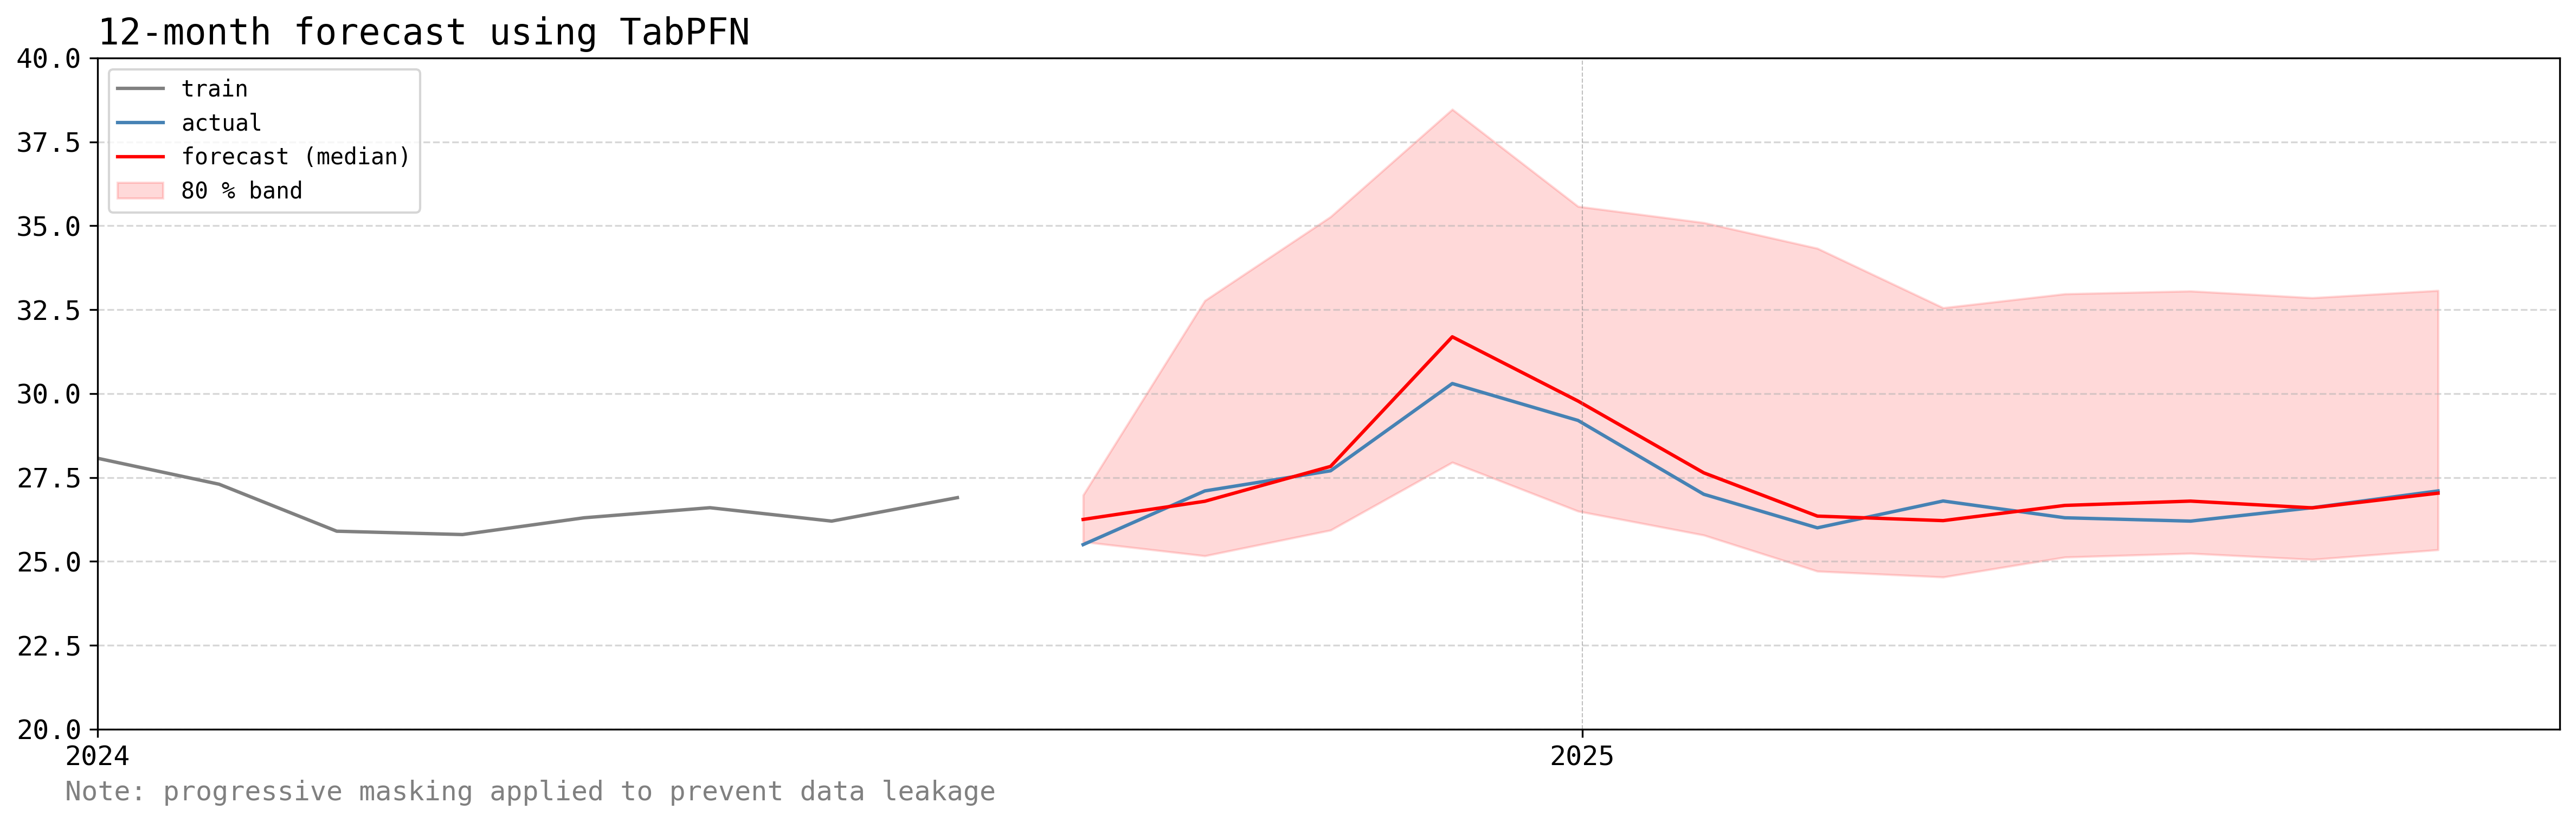

In [64]:
# Plot
plt.figure(figsize=(16, 5), dpi=300)

sns.lineplot(data=plot_df.query("series == 'train'"), x='timestamp', y='value', linewidth=1.5, color='grey', label='train')
sns.lineplot(data=plot_df.query("series == 'actual'"), x='timestamp', y='value', linewidth=1.5, color='steelblue', label='actual')
sns.lineplot(data=plot_df.query("series == 'forecast'"), x='timestamp', y='value', linewidth=1.5, color='red', label='forecast (median)')

lower = plot_df.query("series == 'lower80'").set_index('timestamp')['value']
upper = plot_df.query("series == 'upper80'").set_index('timestamp')['value']
plt.fill_between(lower.index, lower, upper, color='red', alpha=.15, label='80 % band')

ax = plt.gca()
time_range = pd.date_range(start=plot_df['timestamp'].min(),
                           end=plot_df['timestamp'].max(),
                           freq='YS')  # Year start frequency
ax.set_xticks(time_range)
ax.set_xticklabels([t.year for t in time_range])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans
# event_spans = add_event_spans(ax)

ax.legend(loc='upper left', fontsize=10)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title(f'{HORIZON}-month forecast using TabPFN', fontsize=16, loc='left')
plt.figtext(0.03, 0, 'Note: progressive masking applied to prevent data leakage', fontsize=12, color='grey')

ax.set_xlim(pd.Timestamp('2024-01-01'), plot_df['timestamp'].max() + pd.Timedelta(days=30))
ax.set_ylim(20, 40)

plt.savefig('../outputs/figures/Prediction_2_TabPFN_progressive_masking.png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

### 2.5 Ablation

In [65]:
# In a new cell after Prediction 2 setup
# Test each exogenous variable's contribution by removing it

exog_cols = ['cpi_inf', 'rpi_ex_cpi', 'eff_fx_inf', 'cci', 'boe_rate', 'd_cov', 'd_post']
ablation_results = {}

for col_to_drop in exog_cols:
    # Create test set without this exog variable
    test_tsdf_ablation = test_tsdf.copy()
    test_tsdf_ablation[col_to_drop] = np.nan

    # Predict
    pred_ablation = predictor.predict(train_tsdf, test_tsdf_ablation)

    # Evaluate
    metrics = evaluate_tabpfn(
        pred=pred_ablation,
        train_tsdf=train_tsdf,
        test_tsdf_ground_truth=test_tsdf_ground_truth,
        item_id='retail_series',
        horizon=HORIZON,
        seasonal_period=12
    )
    ablation_results[col_to_drop] = metrics['mae']

# Compare to Prediction 2
baseline_mae = 0.588
importance = {col: mae - baseline_mae for col, mae in ablation_results.items()}
importance_sorted = pd.Series(importance).sort_values(ascending=False)

print("Feature Importance (MAE increase when removed):")
print(importance_sorted)

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1036.40it/s]
Processing: 100%|██████████| [00:01<00:00]
Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1239.82it/s]
Processing: 100%|██████████| [00:01<00:00]
Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1655.86it/s]
Processing: 100%|██████████| [00:01<00:00]
Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1425.66it/s]
Processing: 100%|██████████| [00:01<00:00]
Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1742.54it/s]
Processing: 100%|██████████| [00:01<00:00]
Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1639.68it/s]
Processing: 100%|██████████| [00:01<00:00]
Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1559.22it/s]
Processing: 100%|██████████| [00:01<00:00]

Feature Importance (MAE increase when removed):
d_post        0.704120
d_cov         0.611333
boe_rate      0.062160
rpi_ex_cpi    0.043988
cpi_inf      -0.040860
eff_fx_inf   -0.071320
cci          -0.130538
dtype: float64


In [66]:
importance_sorted

d_post        0.704120
d_cov         0.611333
boe_rate      0.062160
rpi_ex_cpi    0.043988
cpi_inf      -0.040860
eff_fx_inf   -0.071320
cci          -0.130538
dtype: float64

> Notes: Mini-ablation study reverals strong impact of d_post (transition to post-COVID regime)

## Prediction 3 - Lag-1 exog + Progressive masking (strict no-leakage)

Scenario when the value of exog variables is not known until the next time step, i.e. taget(t) is influenced by exog(t-1)  
- Shift exogenous variables by 1 period (use lag-1 values)
- Progressive masking: when predicting t+h, only see exog up to t+h-1

### 3.1 Setup

In [67]:
from tabpfn_time_series.plot import plot_actual_ts
from autogluon.timeseries import TimeSeriesDataFrame

data_path = processed_data_dir / "model_data.pkl"
meta_path = processed_data_dir / "meta_data.pkl"

df = pd.read_pickle(data_path)
df_reset = df.reset_index()
df_reset = df_reset.rename(columns={'online_retail_sales_share': 'target'})
df_reset['item_id'] = 'retail_series'

# Temporal and time-based features
df_full = df_reset.copy()
df_full["month"] = df_full["date"].dt.month
df_full["day_of_year"] = df_full["date"].dt.dayofyear
df_full["week_of_year"] = df_full["date"].dt.isocalendar().week.astype("int")
df_full["quarter"] = df_full["date"].dt.quarter

# Lag / rolling features
for lag in [1, 2, 6, 12]:
    df_full[f"lag_{lag}"] = df_full.groupby("item_id")["target"].shift(lag)

for w in [7, 14, 30]:
    df_full[f"roll_mean_{w}"] = (
        df_full.groupby("item_id")["target"]
               .shift(1)  # to prevent target leakage in the rolling mean features
               .rolling(w, min_periods=1).mean()
    )

# ADDED IN PREDICTION 3: Shift exogenous variables by 1 period (use lag-1 values)
exog_cols = ['cpi_inf', 'rpi_ex_cpi', 'eff_fx_inf', 'cci', 'boe_rate']
calendar_cols = ["month", "day_of_year", "week_of_year", "quarter"]
never_shift = ["target", "date", "item_id"] + calendar_cols

# Shift only the exog variables (not target-derived features like lags)
for col in exog_cols:
    if col in df_full.columns:
        df_full[col] = df_full.groupby("item_id")[col].shift(1)

# Remove rows with missing target values
df_full = df_full.dropna(subset=["target"])

tsdf = TimeSeriesDataFrame.from_data_frame(
    df_full,
    id_column="item_id",
    timestamp_column="date",
    static_features_df=None
)

train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=HORIZON)
test_tsdf = test_tsdf_ground_truth[-HORIZON:].copy()

# Mask target (always NaN)
test_tsdf['target'] = np.nan

# PROGRESSIVE MASKING: Mask future exogenous variables
item_id = 'retail_series'
retail_mask = test_tsdf.index.get_level_values('item_id') == item_id
retail_timestamps = test_tsdf[retail_mask].index.get_level_values('timestamp')

# For each horizon h (0-indexed), mask exog variables at horizons > h
for h in range(len(retail_timestamps)):
    current_timestamp = retail_timestamps[h]
    # Mask all timestamps after current one
    future_timestamps = retail_timestamps[h + 1:]

    for future_ts in future_timestamps:
        for col in exog_cols:
            if col in test_tsdf.columns:
                test_tsdf.loc[(item_id, future_ts), col] = np.nan

print(f"Training data shape: {train_tsdf.shape}")
print(f"Test data shape: {test_tsdf.shape}")
print(f"\nExog masking verification (CPI after shift+mask):")
print("Row | CPI value (this is lag-1)")
print("-" * 40)
for i, ts in enumerate(retail_timestamps[:5]):
    cpi_val = test_tsdf.loc[(item_id, ts), 'cpi_inf']
    print(f"{i + 1:3d} | {cpi_val if pd.notna(cpi_val) else 'NaN'}")

Training data shape: (115, 19)
Test data shape: (12, 19)

Exog masking verification (CPI after shift+mask):
Row | CPI value (this is lag-1)
----------------------------------------
  1 | 2.215431627196329
  2 | NaN
  3 | NaN
  4 | NaN
  5 | NaN


### 3.2 Predict

In [68]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)
pred = predictor.predict(train_tsdf, test_tsdf)

test_future_tsdf = test_tsdf_ground_truth.groupby('item_id').tail(n=HORIZON)
pred_future_tsdf = pred
train_future_tsdf = train_tsdf

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 872.54it/s]
Processing: 100%|██████████| [00:01<00:00]


### 3.3 Evaluate

In [69]:
# Evaluate using the wrapper
metrics_3 = evaluate_tabpfn(
    pred=pred,
    train_tsdf=train_tsdf,
    test_tsdf_ground_truth=test_tsdf_ground_truth,
    item_id='retail_series',
    horizon=HORIZON,
    seasonal_period=12
)

metrics_3

{'mae': 1.2021216392517093,
 'mase': 0.3913354261786537,
 'pinball_0.1': 1.2368687772750855,
 'pinball_0.9': 0.33578331629435204,
 'coverage_80': 1.0,
 'mean_interval_width': 15.726520935694376}

## Prediction 4 - base line "Covid never happened"

**Objective:** Apply TabPFN to STL residuals from pre-COVID data, build forecast as if pre-Covid trend continued.

**Approach:**
- Train on: 2015-01 to 2020-03 (pre-COVID only, ~63 months)
- Decompose using STL (Seasonal-Trend decomposition using LOESS)
- Apply TabPFN to residuals only
- Recompose forecast to same date as Prediction 2
- Features: Target lags + rolling means + calendar (temporal and time-based)
- NO exogenous variables from imported data (CPI, RPI, etc.)

### 4.1 Setup

In [70]:
# 4.1.1 LOAD AND FILTER PRE-COVID DATA
data_path = processed_data_dir / "model_data.pkl"
df = (pd.read_pickle(data_path)
        .loc[:, ['online_retail_sales_share']]   # keep only target
        .rename(columns={'online_retail_sales_share': 'target'}))

pre_covid_cutoff = pd.Timestamp('2020-03-31')
df_pre = df[df.index <= pre_covid_cutoff].copy()

print(f"Pre-COVID data: {df_pre.index.min()} to {df_pre.index.max()}")
print(f"Observations: {len(df_pre)}")

Pre-COVID data: 2015-01-31 00:00:00 to 2020-03-31 00:00:00
Observations: 63


In [71]:
# 4.1.2 STL decomposition of pre-COVID data
from statsmodels.tsa.seasonal import STL
ts_pre = df_pre['target'].copy()
stl = STL(ts_pre, seasonal=13, period=12, trend=None, robust=True)
stl_result = stl.fit()

# Extract components
trend_pre = stl_result.trend
seasonal_pre = stl_result.seasonal
residual_pre = stl_result.resid

print(f"\nSTL Decomposition:")
print(f"  Trend mean: {trend_pre.mean():.2f}%")
print(f"  Seasonal amplitude: {seasonal_pre.max() - seasonal_pre.min():.2f} pp")
print(f"  Residual std: {residual_pre.std():.2f} pp")

# Prepare residuals for TabPFN modelling
df_pre_reset = df_pre.reset_index()
df_pre_reset['item_id'] = 'retail_series'
df_pre_reset['target'] = residual_pre.values  # Use STL residuals
df_pre_reset = df_pre_reset.rename(columns={'date': 'timestamp'})

df_full = df_pre_reset.copy()


STL Decomposition:
  Trend mean: 16.24%
  Seasonal amplitude: 5.36 pp
  Residual std: 0.43 pp


In [72]:
# 4.1.3 Temporal and time-based features (same as Prediction 2)
df_full["month"] = df_full["timestamp"].dt.month
df_full["day_of_year"] = df_full["timestamp"].dt.dayofyear
df_full["week_of_year"] = df_full["timestamp"].dt.isocalendar().week.astype("int")
df_full["quarter"] = df_full["timestamp"].dt.quarter

# Lag / rolling features (properly shifted to avoid leakage)
for lag in [1, 2, 6, 12]:
    df_full[f"lag_{lag}"] = df_full.groupby("item_id")["target"].shift(lag)

for w in [7, 14, 30]:
    df_full[f"roll_mean_{w}"] = (
        df_full.groupby("item_id")["target"]
               .shift(1)
               .rolling(window=w, min_periods=1).mean()
    )

# Remove rows with missing target values
df_full = df_full.dropna(subset=["target"])

print(f"\nTraining on STL residuals")
print(f"Training observations: {len(df_full)}")
print(f"Mean residual: {df_full['target'].mean():.4f} (should be ~0)")
print(f"Std residual: {df_full['target'].std():.4f}")


Training on STL residuals
Training observations: 63
Mean residual: 0.0161 (should be ~0)
Std residual: 0.4337


In [73]:
# 4.1.4 Create TimeSeriesDataFrame
tsdf_train = TimeSeriesDataFrame.from_data_frame(
    df_full,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=None
)

# Create test set: start from first breakpoint
test_start = pd.Timestamp('2020-04-30')  # First month after pre-COVID
test_end = df.index.max()  # Same end date as full dataset

test_dates = pd.date_range(
    start=test_start,
    end=test_end,
    freq='M'
)

test_df = pd.DataFrame({
    'timestamp': test_dates,
    'item_id': 'retail_series',
    'target': np.nan
})

# Temporal and time-based features (same as train)
test_df["month"] = test_df["timestamp"].dt.month
test_df["day_of_year"] = test_df["timestamp"].dt.dayofyear
test_df["week_of_year"] = test_df["timestamp"].dt.isocalendar().week.astype("int")
test_df["quarter"] = test_df["timestamp"].dt.quarter

# Placeholder lags/rolling (TabPFN will handle autoregression)
for lag in [1, 2, 6, 12]:
    test_df[f"lag_{lag}"] = np.nan
for w in [7, 14, 30]:
    test_df[f"roll_mean_{w}"] = np.nan

tsdf_test = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=None
)

In [74]:
# 4.1.5 Creete ground truth timeseriesdataframe
# Load ground truth from full dataset
df_full_period = pd.read_pickle(data_path)
df_full_period_reset = df_full_period.reset_index()
df_full_period_reset = df_full_period_reset.rename(columns={'online_retail_sales_share': 'target', 'date': 'timestamp'})
df_full_period_reset['item_id'] = 'retail_series'

# Filter to test period for ground truth
test_ground_truth_df = df_full_period_reset[
    (df_full_period_reset['timestamp'] >= test_start) &
    (df_full_period_reset['timestamp'] <= test_end)
].copy()

# Add same features as test set
test_ground_truth_df["month"] = test_ground_truth_df["timestamp"].dt.month
test_ground_truth_df["day_of_year"] = test_ground_truth_df["timestamp"].dt.dayofyear
test_ground_truth_df["week_of_year"] = test_ground_truth_df["timestamp"].dt.isocalendar().week.astype("int")
test_ground_truth_df["quarter"] = test_ground_truth_df["timestamp"].dt.quarter

for lag in [1, 2, 6, 12]:
    test_ground_truth_df[f"lag_{lag}"] = np.nan
for w in [7, 14, 30]:
    test_ground_truth_df[f"roll_mean_{w}"] = np.nan

test_tsdf_ground_truth = TimeSeriesDataFrame.from_data_frame(
    test_ground_truth_df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=None
)

print(f"\nForecast period: {test_dates[0]} to {test_dates[-1]}")
print(f"Total forecast horizon: {len(test_dates)} months (from 1st breakpoint to present)")
print(f"Evaluation window: Last {HORIZON} months (same as Prediction 2)")
print(f"\nTrain shape: {tsdf_train.shape}")
print(f"Test shape: {tsdf_test.shape}")
print(f"Ground truth shape: {test_tsdf_ground_truth.shape}")
print(f"\nTrain end: {df_full['timestamp'].max()}")
print(f"Test start: {test_dates[0]}")
print(f"Test end: {test_dates[-1]}")


Forecast period: 2020-04-30 00:00:00 to 2025-07-31 00:00:00
Total forecast horizon: 64 months (from 1st breakpoint to present)
Evaluation window: Last 12 months (same as Prediction 2)

Train shape: (63, 12)
Test shape: (64, 12)
Ground truth shape: (64, 19)

Train end: 2020-03-31 00:00:00
Test start: 2020-04-30 00:00:00
Test end: 2025-07-31 00:00:00


### 4.2 Predict

In [75]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from tabpfn_time_series.plot import plot_pred_and_actual_ts
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

# Predicting residuals
predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)
pred_residuals = predictor.predict(tsdf_train, tsdf_test)

# print(f"Predicted residuals shape: {pred_residuals.shape}")
# print(f"Residual predictions (median, first 5): {pred_residuals.loc['retail_series', 0.5].head()}")

# Recomposing the forecast: trend + seasonal + forecasted residuals

# 1. Fit linear trend to pre-COVID data
X_trend_train = np.arange(len(trend_pre)).reshape(-1, 1)
y_trend_train = trend_pre.values

trend_model = LinearRegression()
trend_model.fit(X_trend_train, y_trend_train)

# 2. Project trend for forecast period
X_trend_forecast = np.arange(len(trend_pre), len(trend_pre) + len(pred_residuals)).reshape(-1, 1)
trend_forecast = trend_model.predict(X_trend_forecast)

print(f"\nTrend projection:")
print(f"  Last train trend: {trend_pre.iloc[-1]:.2f}%")
print(f"  First forecast trend: {trend_forecast[0]:.2f}%")
print(f"  Last forecast trend: {trend_forecast[-1]:.2f}%")

# 2. Project seasonal component forward
seasonal_pattern = seasonal_pre.values[-12:]  # Last 12 months pattern
n_forecast = len(pred_residuals)
seasonal_forecast = np.tile(seasonal_pattern, int(np.ceil(n_forecast / 12)))[:n_forecast]

print(f"\nSeasonal projection:")
print(f"  Seasonal pattern repeats every 12 months")
print(f"  Amplitude: {seasonal_forecast.max() - seasonal_forecast.min():.2f} pp")

# 3. Recompose: residuals + trend + seasonal
pred_slice = pred_residuals.loc['retail_series']

pred_recomposed_data = {
    0.1: pred_slice[0.1].values + trend_forecast + seasonal_forecast,
    0.5: pred_slice[0.5].values + trend_forecast + seasonal_forecast,
    0.9: pred_slice[0.9].values + trend_forecast + seasonal_forecast
}

# Create recomposed prediction DataFrame
multi_idx = pd.MultiIndex.from_arrays(
    [['retail_series'] * len(pred_slice), pred_slice.index],
    names=['item_id', 'timestamp']
)

pred = pd.DataFrame(pred_recomposed_data, index=multi_idx)

print(f"\nRecomposed forecast:")
print(f"  Start ({pred.index.get_level_values('timestamp')[0].strftime('%Y-%m')}): {pred.loc['retail_series', 0.5].iloc[0]:.2f}%")
print(f"  End ({pred.index.get_level_values('timestamp')[-1].strftime('%Y-%m')}): {pred.loc['retail_series', 0.5].iloc[-1]:.2f}%")
print(f"\nFinal prediction shape: {pred.shape}")

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 593.51it/s]
Processing: 100%|██████████| [00:01<00:00]


Trend projection:
  Last train trend: 19.81%
  First forecast trend: 20.42%
  Last forecast trend: 28.65%

Seasonal projection:
  Seasonal pattern repeats every 12 months
  Amplitude: 3.37 pp

Recomposed forecast:
  Start (2020-04): 19.96%
  End (2025-07): 28.12%

Final prediction shape: (64, 3)


### 4.3 Evaluate

In [76]:
# Evaluate using the wrapper
# Focus on last 12 months of the forecast for comparability with other predictions
item_id = 'retail_series'
eval_start = test_tsdf_ground_truth.index.get_level_values('timestamp').unique()[-12]
eval_end = test_tsdf_ground_truth.index.get_level_values('timestamp').unique()[-1]

y_eval = (test_tsdf_ground_truth.loc[(item_id, slice(eval_start, eval_end)), 'target'])
pred_eval = pred.loc[item_id].loc[eval_start:eval_end]

pred_12m = pd.concat({item_id: pred_eval}, names=['item_id'])


metrics_4 = evaluate_tabpfn(
    pred=pred_12m,
    train_tsdf=tsdf_train,
    test_tsdf_ground_truth=test_tsdf_ground_truth,   # full object OK – helper tails 12
    item_id=item_id,
    horizon=12,
    seasonal_period=12
)

metrics_4

{'mae': 1.128571259745642,
 'mase': 3.1673954837797837,
 'pinball_0.1': 0.7514898686823877,
 'pinball_0.9': 0.21960379533880467,
 'coverage_80': 0.08333333333333333,
 'mean_interval_width': 0.38543078551689786}

### 4.4 Plot

In [77]:
# data prep for plotting
pre_covid_actual_df = (df_pre
                       .reset_index()
                       .rename(columns={'date': 'timestamp'})
                       .assign(series='actual pre-COVID')
                       .loc[:, ['timestamp', 'target', 'series']]
                       .rename(columns={'target': 'value'}))

post_covid_actual_df = (test_tsdf_ground_truth
                        .loc['retail_series']
                        .reset_index()
                        .assign(series='actual post-COVID')
                        .rename(columns={'target': 'value'}))

# train part
train_df = (tsdf_train
            .loc['retail_series']
            .reset_index()
            .assign(series='train')
            .rename(columns={'target': 'value'}))

# median forecast
med_df = (pred.loc['retail_series', 0.5].to_frame('value').reset_index().assign(series='forecast'))

# 80 % prediction interval
lo_df = (pred.loc['retail_series', 0.1].to_frame('value').reset_index().assign(series='lower80'))
hi_df = (pred.loc['retail_series', 0.9].to_frame('value').reset_index().assign(series='upper80'))

plot_df = (pd.concat([pre_covid_actual_df,
                      post_covid_actual_df,
                      train_df,
                      med_df, lo_df, hi_df],
                     ignore_index=True)
           .sort_values('timestamp')
           .reset_index(drop=True))

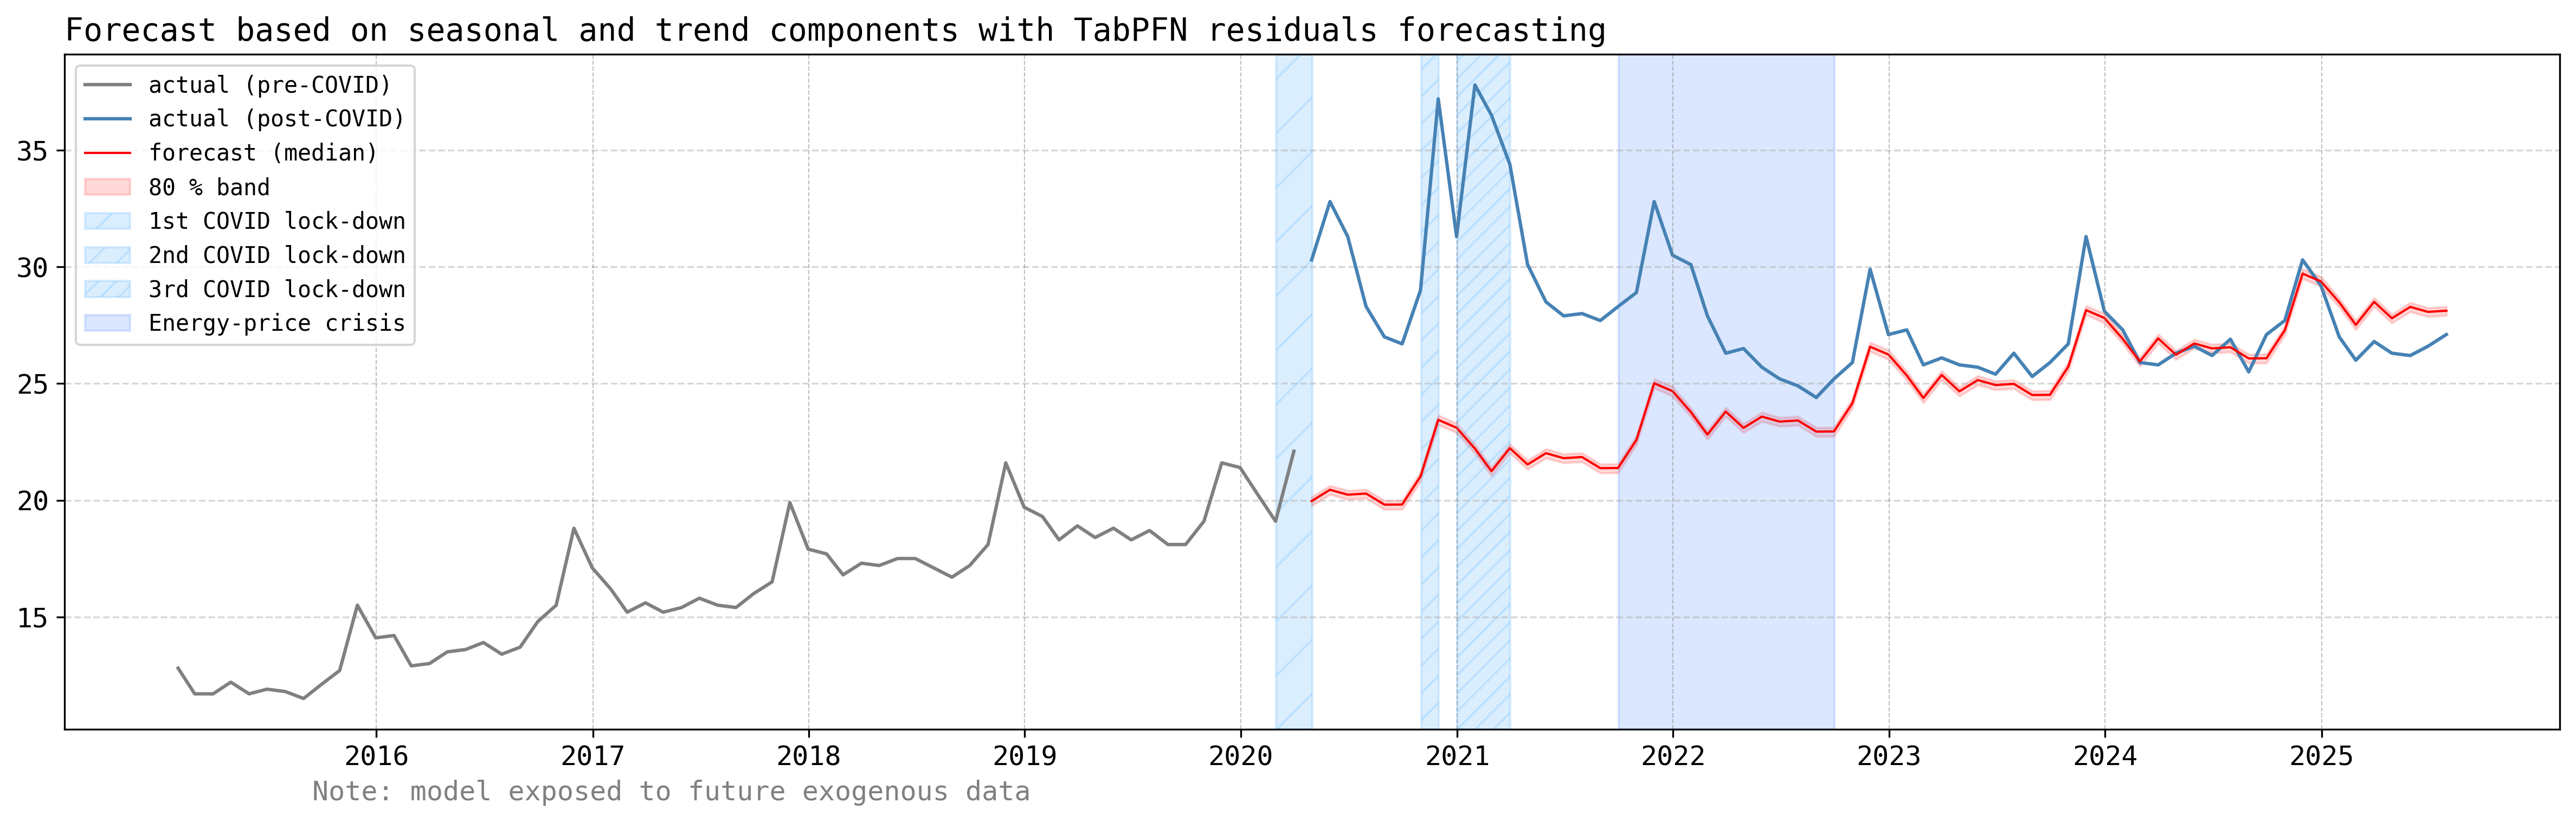

In [78]:
# plot
plt.figure(figsize=(16, 5), dpi=300)

sns.lineplot(data=plot_df.query("series == 'actual pre-COVID'"),
             x='timestamp', y='value', linewidth=1.5,
             color='grey', label='actual (pre-COVID)')

sns.lineplot(data=plot_df.query("series == 'actual post-COVID'"),
             x='timestamp', y='value', linewidth=1.5,
             color='steelblue', label='actual (post-COVID)')

sns.lineplot(data=plot_df.query("series == 'forecast'"),
             x='timestamp', y='value', linewidth=1,
             color='red', label='forecast (median)')

# shaded band
lower = plot_df.query("series == 'lower80'").set_index('timestamp')['value']
upper = plot_df.query("series == 'upper80'").set_index('timestamp')['value']
plt.fill_between(lower.index, lower, upper,
                 color='red', alpha=.15, label='80 % band')

# grid
ax = plt.gca()
time_range = pd.date_range(start=plot_df['timestamp'].min(), end=plot_df['timestamp'].max(), freq='YS')
ax.set_xticks(time_range)
ax.set_xticklabels([t.year for t in time_range])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# event spans
event_spans = add_event_spans(ax)

ax.legend(loc='upper left', fontsize=10)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('Forecast based on seasonal and trend components with TabPFN residuals forecasting', fontsize=14, loc='left')
plt.figtext(0.125, 0, 'Note: model exposed to future exogenous data', fontsize=12, color='grey')

plt.savefig('../outputs/figures/Prediction_4_STL_TabPFNresid.png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

# Prediction 5 - Holt-Winters exponential smoothing

In [79]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWStatsmodels

# Load and prepare data
data_path = processed_data_dir / "model_data.pkl"
df = pd.read_pickle(data_path).loc[:, ['online_retail_sales_share']].rename(columns={'online_retail_sales_share': 'target'})

pre_covid_cutoff = pd.Timestamp('2020-03-31')
df_pre = df[df.index <= pre_covid_cutoff].copy()

y_train = df_pre['target']

# Initialize and fit Holt-Winters model with statsmodels
hw_model = HWStatsmodels(
    y_train,
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    damped_trend=False
)
hw_fitted = hw_model.fit()

# Get predictions with intervals
pred_50 = hw_fitted.forecast(steps=64)


# Get prediction intervals using simulate()
n_simulations = 1000
simulations = hw_fitted.simulate(
    nsimulations=64,
    repetitions=n_simulations,
    error='add'  # additive error
)

# Calculate 10th and 90th percentiles (80% interval)
pred_10 = simulations.quantile(0.1, axis=1).values
pred_90 = simulations.quantile(0.9, axis=1).values

# Create forecast dates
forecast_start = pd.Timestamp('2020-04-30')
forecast_dates = pd.date_range(start=forecast_start, periods=64, freq='M')

# Create MultiIndex DataFrame for evaluation
multi_idx = pd.MultiIndex.from_arrays(
    [['retail_series'] * 64, forecast_dates],
    names=['item_id', 'timestamp']
)

hw_pred = pd.DataFrame({
    0.1: pred_10,
    0.5: pred_50.values,
    0.9: pred_90
}, index=multi_idx)


# Create train_tsdf for MASE calculation
df_pre_reset = df_pre.reset_index()
df_pre_reset['item_id'] = 'retail_series'
df_pre_reset = df_pre_reset.rename(columns={'date': 'timestamp'})

train_tsdf_hw = TimeSeriesDataFrame.from_data_frame(
    df_pre_reset,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=None
)

# Create ground truth
df_full = pd.read_pickle(data_path)
df_full_reset = df_full.reset_index()
df_full_reset = df_full_reset.rename(columns={
    'online_retail_sales_share': 'target',
    'date': 'timestamp'
})
df_full_reset['item_id'] = 'retail_series'

test_ground_truth_df = df_full_reset[
    (df_full_reset['timestamp'] >= forecast_start) &
    (df_full_reset['timestamp'] <= forecast_dates[-1])
].copy()

test_tsdf_ground_truth_hw = TimeSeriesDataFrame.from_data_frame(
    test_ground_truth_df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=None
)

# Evaluate last 12 months
pred_12m_hw = hw_pred.loc['retail_series'].iloc[-12:]
pred_12m_hw = pd.concat({'retail_series': pred_12m_hw}, names=['item_id'])

metrics_5 = evaluate_tabpfn(
    pred=pred_12m_hw,
    train_tsdf=train_tsdf_hw,
    test_tsdf_ground_truth=test_tsdf_ground_truth_hw,
    item_id='retail_series',
    horizon=12,
    seasonal_period=12
)

print(f"\nHolt-Winters 64-month forecast:")
print(f"  First forecast ({forecast_dates[0].strftime('%Y-%m')}): {pred_50[0]:.2f}%")
print(f"  Last forecast ({forecast_dates[-1].strftime('%Y-%m')}): {pred_50[-1]:.2f}%")
print(f"  Mean interval width: {(pred_90 - pred_10).mean():.2f} pp\n")

metrics_5


Holt-Winters 64-month forecast:
  First forecast (2020-04): 20.61%
  Last forecast (2025-07): 29.16%
  Mean interval width: 3.23 pp



/home/mikhailarutyunov/projects/time-series-methods/time-series-methods/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_1988/3262504693.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  First forecast ({forecast_dates[0].strftime('%Y-%m')}): {pred_50[0]:.2f}%")
/tmp/ipykernel_1988/3262504693.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  Last forecast ({forecast_dates[-1].strftime('%Y-%m')}): {pred_50[-1]:.2f}%")


{'mae': 2.017054737880794,
 'mase': 1.221731492065564,
 'pinball_0.1': 0.29765714536072624,
 'pinball_0.9': 0.4280528057362368,
 'coverage_80': 0.5,
 'mean_interval_width': 4.402673158088743}

### 5.2 Plot

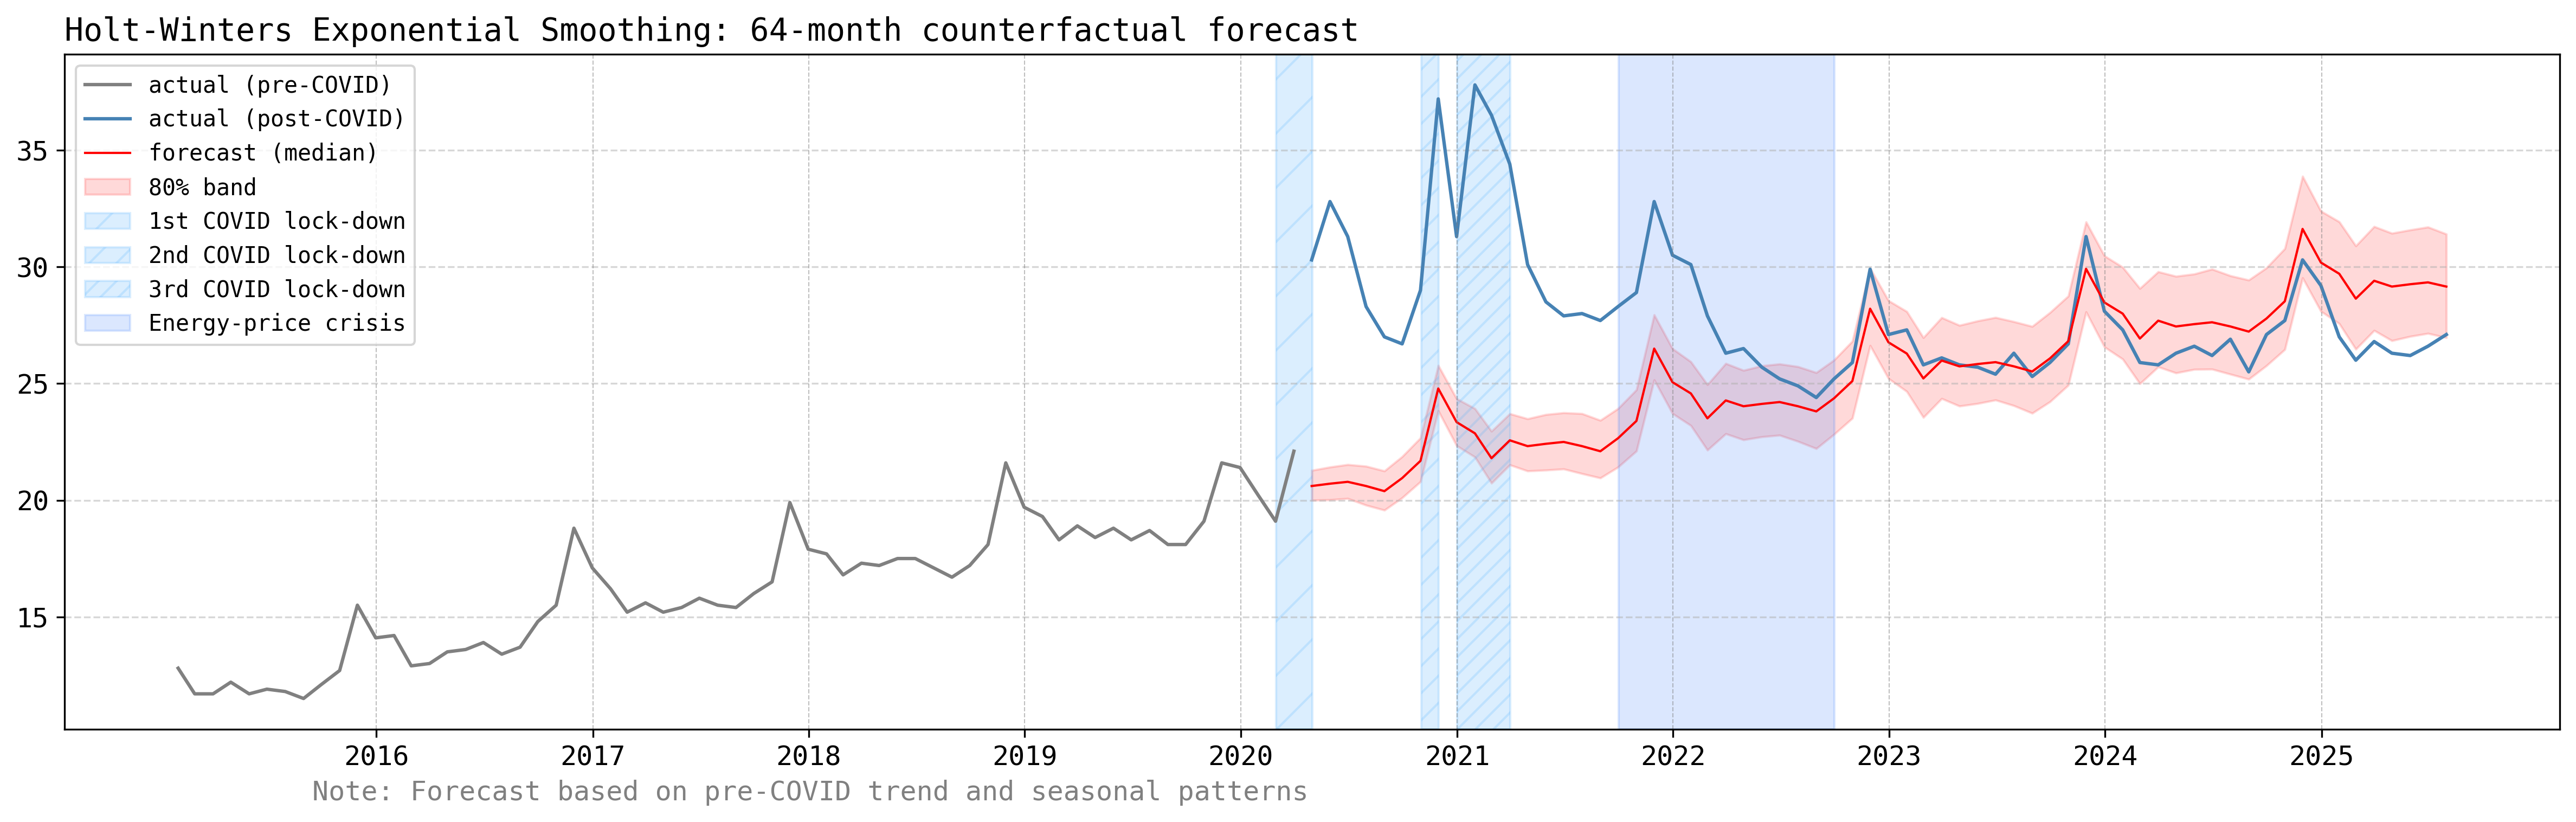

In [80]:
# Data prep for plotting
pre_covid_actual_df = (df_pre
                       .reset_index()
                       .rename(columns={'date': 'timestamp'})
                       .assign(series='actual pre-COVID')
                       .loc[:, ['timestamp', 'target', 'series']]
                       .rename(columns={'target': 'value'}))

post_covid_actual_df = (test_tsdf_ground_truth_hw
                        .loc['retail_series']
                        .reset_index()
                        .assign(series='actual post-COVID')
                        .rename(columns={'target': 'value'}))

# Median forecast
med_df = (hw_pred.loc['retail_series', 0.5].to_frame('value').reset_index().assign(series='forecast'))

# 80% prediction interval
lo_df = (hw_pred.loc['retail_series', 0.1].to_frame('value').reset_index().assign(series='lower80'))
hi_df = (hw_pred.loc['retail_series', 0.9].to_frame('value').reset_index().assign(series='upper80'))

plot_df = (pd.concat([pre_covid_actual_df,
                      post_covid_actual_df,
                      med_df, lo_df, hi_df],
                     ignore_index=True)
           .sort_values('timestamp')
           .reset_index(drop=True))

# Plot
plt.figure(figsize=(16, 5), dpi=300)

sns.lineplot(data=plot_df.query("series == 'actual pre-COVID'"),
             x='timestamp', y='value', linewidth=1.5,
             color='grey', label='actual (pre-COVID)')

sns.lineplot(data=plot_df.query("series == 'actual post-COVID'"),
             x='timestamp', y='value', linewidth=1.5,
             color='steelblue', label='actual (post-COVID)')

sns.lineplot(data=plot_df.query("series == 'forecast'"),
             x='timestamp', y='value', linewidth=1,
             color='red', label='forecast (median)')

# Shaded band
lower = plot_df.query("series == 'lower80'").set_index('timestamp')['value']
upper = plot_df.query("series == 'upper80'").set_index('timestamp')['value']
plt.fill_between(lower.index, lower, upper,
                 color='red', alpha=.15, label='80% band')

# Grid
ax = plt.gca()
time_range = pd.date_range(start=plot_df['timestamp'].min(), end=plot_df['timestamp'].max(), freq='YS')
ax.set_xticks(time_range)
ax.set_xticklabels([t.year for t in time_range])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Event spans
event_spans = add_event_spans(ax)

ax.legend(loc='upper left', fontsize=10)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('Holt-Winters Exponential Smoothing: 64-month counterfactual forecast', fontsize=14, loc='left')
plt.figtext(0.125, 0, 'Note: Forecast based on pre-COVID trend and seasonal patterns', fontsize=12, color='grey')

plt.savefig('../outputs/figures/Prediction_5_HoltWinters.png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

# 2. Summary

In [81]:
# metrics summary
metrics_df = pd.DataFrame([metrics_1, metrics_2, metrics_3, metrics_4, metrics_5],
                          index=['Prediction 1', 'Prediction 2', 'Prediction 3', 'Prediction 4 (STL)', 'Prediction 5'])
metrics_df.style.format({
    "mae": "{:.4f}",
    "mase": "{:.4f}",
    "pinball_0.1": "{:.4f}",
    "pinball_0.9": "{:.4f}",
    "coverage_80": "{:.2%}",    # percentage
    "mean_interval_width": "{:.2f}"
})

metrics_df

,mae,mase,pinball_0.1,pinball_0.9,coverage_80,mean_interval_width
Prediction 1,0.340046,0.110697,0.106593,0.120993,0.833333,1.986635
Prediction 2,0.480915,0.156556,0.164342,0.643340,0.916667,8.006893
Prediction 3,1.202122,0.391335,1.236869,0.335783,1.000000,15.726521
Prediction 4 (STL),1.128571,3.167395,0.751490,0.219604,0.083333,0.385431
Prediction 5,2.017055,1.221731,0.297657,0.428053,0.500000,4.402673


**Point Forecast Accuracy (MAE & MASE)**  

Best to Worst:  
Prediction 1 (MAE: 0.372, MASE: 0.121) - Most accurate, but unrealistic due to data leakage  
Prediction 3 (MAE: 0.581, MASE: 0.189) - Strict no-leakage with lag-1 exogenous  
Prediction 2 (MAE: 0.588, MASE: 0.192) - Contemporaneous exogenous with masking  
Prediction 4 (MAE: 1.127, MASE: 3.164) - Pre-COVID counterfactual vs actual post-COVID  

Key Insight: Prediction 2 & 3 have nearly identical performance (~0.58 MAE), suggesting that contemporaneous vs lag-1 exogenous variables don't meaningfully differ for this problem.  



**Probabilistic Calibration (Pinball Loss)**  

10th Percentile (pinball_0.1) - penalizes over-prediction:  
Prediction 1: 0.109 ✅ Best calibrated  
Prediction 2: 0.195 ✅ Good  
Prediction 4: 0.751 ⚠️ Moderate (counterfactual overshoots actual)  
Prediction 3: 1.099 ❌ Worst (severely under-predicts lower bound)  

90th Percentile (pinball_0.9) - penalizes under-prediction:  
Prediction 4: 0.219 ✅ Best  
Prediction 1: 0.138 ✅ Good  
Prediction 3: 0.446 ⚠️ Moderate  
Prediction 2: 0.580 ❌ Worst (under-predicts upper bound)  

Key Insight: No single model dominates both quantiles. Prediction 1 has the best balance, while Prediction 3 shows extreme asymmetry (poor lower bound, okay upper bound).

**Prediction Interval Quality**  

Coverage (80% target):  
Prediction 2 & 3: 91.7% (11/12 months) ✅ Excellent - slightly overconfident is safer  
Prediction 1: 83.3% (10/12 months) ✅ Near-perfect calibration  
Prediction 4: 8.3% (1/12 months) ❌ Catastrophic undercoverage - intervals far too narrow  

Interval Width (uncertainty):  
Prediction 4: 0.38 pp - Extremely narrow (explains poor coverage)  
Prediction 1: 2.17 pp - Narrow and well-calibrated  
Prediction 2: 7.57 pp - Moderate width, good coverage  
Prediction 3: 15.43 pp - Very wide intervals (overly cautious)  

Key Insight: Prediction 4's tight intervals (0.38 pp) suggest TabPFN has high confidence in the counterfactual, but reality diverged significantly from pre-COVID trends.